# Example on how to use some of the functions in extraction_tools

I wrote the functions in extraction_tools to be useful when we want to extract the background-subtracted spectra of individual point-sources in MUSE data, like globular clusters or nuclear star clusters (e.g. Fahrion et al. 2020, A&A, 637, 26; Fahrion et al. 2021, A&A, 650, 137).

To really use these functions, we therefore need a MUSE cube. They are a bit big to host on github, but many can be downloaded from ESO's science archive: http://archive.eso.org

For example, we could download the MUSE cube of the infamous NGC1052-DF (Programme ID 2101.B-5008, PI: E. Emsellem, see Emsellem et al. 2019, A&A, 625, 76 or Fensch et al.2019, A&A, 625, 77F)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import extraction_tools as tools


In [12]:
#path to the file
file = '/Users/katja.fahrion/Documents/Data/MUSE_Data/DF2/DF2_MUSE.fits'

Text(0, 0.5, 'y (pix)')

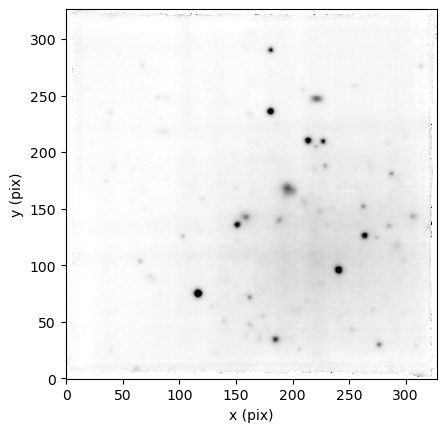

In [13]:
#how we can open the file in any way to get the data cube (e.g. using MPDAF),
# extraction_tools also has a simple function:

data, stat, wave = tools.read_MUSE(file)

#plot an image (combined along wavelength)
img = np.nanmedian(data[100:800, :, :], axis=0)

fig, ax = plt.subplots()
ax.imshow(img, origin='lower', cmap='Greys', vmin=0, vmax=10)
#Yes there is a galaxy hiding, but we only want to see the star clusters anyway
ax.set_xlabel('x (pix)')
ax.set_ylabel('y (pix)')

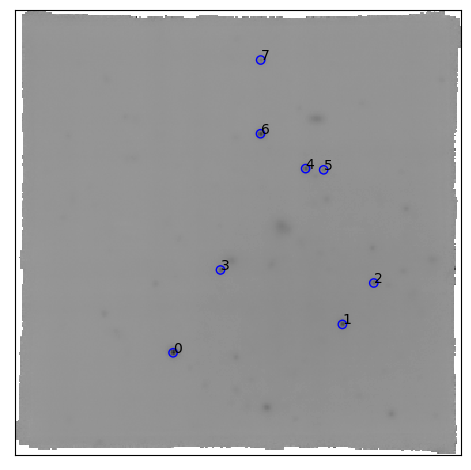

In [14]:
#Now lets run some simple source finding to detect the star clusters.
#this is based on daofind in photutils

x, y = tools.SourceFinder(img, fwhm=4, threshold=3, plot=True, show_IDs=True)



In [15]:
#Get spectrum of source #4

spec, spec_bg = tools.extract_spectrum(data, x=x[4], y=y[4], 
                                       psf=True, #use Gaussian weighted extraction
                                       fwhm=4, #with this fwhm
                                       bg=True, #extract background annulus spectrum
                                       r = 10, #extraction radius of source in pixel, only relevant if psf=False
                                       r1 = 7, #inner annulus
                                       r2 = 11) #outer annulus
                                       

S/N = 28.6


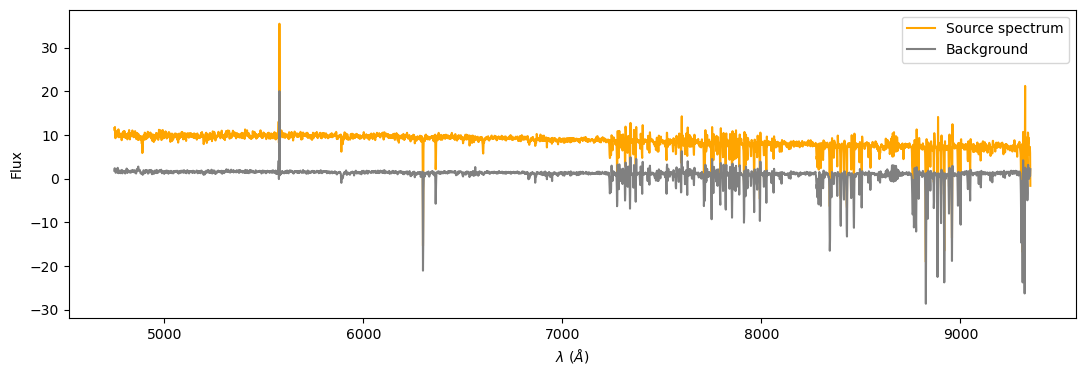

In [16]:
#plot
fig, ax = plt.subplots(figsize=[13, 4])
ax.plot(wave, spec, c='orange', label='Source spectrum')
ax.plot(wave, spec_bg, c='grey', label='Background')
ax.set_xlabel(r'$\lambda$ ($\AA$)')
ax.set_ylabel(r'Flux')
ax.legend()

#lots of sky lines, but also some real ones

#Signal-to-noise (based on the scatter in the spectrum, not the noise cube here)
snr = tools.calc_SNR(wave, spec,
                     der = False) #can be true to use the DER_SNR formula
print('S/N = {0:.1f}'.format(snr))

one could now subtract the background from the source but given that there is barely anything in the background, I would not do that


In [17]:
#We can also extract the variance spectrum
#need to give it the noise extension from the data cube
var_spec, var_spec_bg = tools.extract_spectrum(stat, x=x[4], y=y[4], 
                                                psf=True, #use Gaussian weighted extraction
                                                fwhm=4, #with this fwhm
                                                bg=True, #extract background annulus spectrum
                                                r = 10, #extraction radius of source in pixel, only relevant if psf=False
                                                r1 = 7, #inner annulus
                                                r2 = 11, #outer annulus
                                                var = True) #shows that this is a noise spectrum

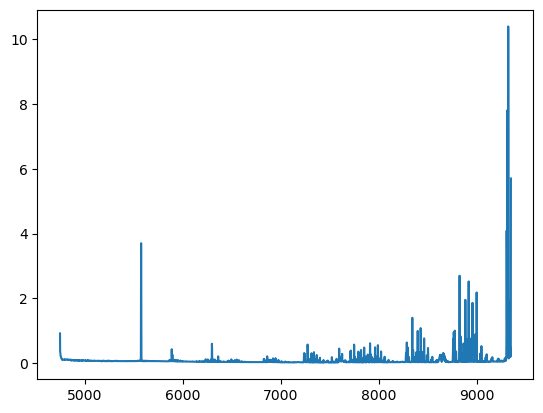

In [18]:
np.shape(spec)

fig, ax = plt.subplots()
ax.plot(wave, var_spec)

In [19]:
#now fit with ppxf_wrapper

import pPXF_wrapper.ppxf_wrapper as ppxf_wrapper
from astropy.table import Table
tab = Table(data=[wave, spec, var_spec], names=['wave', 'spec', 'var_spec'])
tab.write('/Users/katja.fahrion/Documents/Scripts/MyPackages/pPXF_wrapper/pPXF_wrapper/examples/spectra/DF2_GC.dat',
          format='ascii', overwrite=True)

8.867607953073056 8.86782176192044
1880 1881
/Users/katja.fahrion/Documents/Scripts/MyPackages/pPXF_wrapper/pPXF_wrapper/templates//EMILES_Basti/Ebi1.30*.fits None None


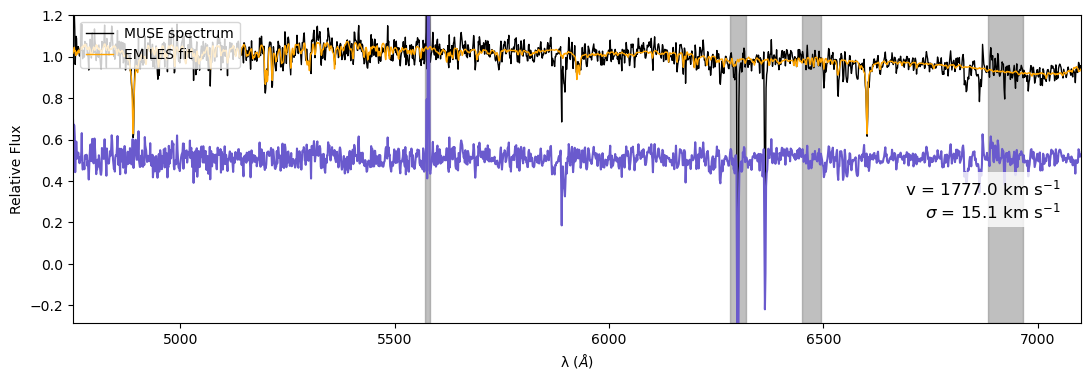

In [20]:
ppw = ppxf_wrapper.ppxf_wrapper(wave, spec, noise_spec=var_spec, 
                                 vel = 1700, #guess for velocity
                                      lam_range=[4700, 7100], #wavelength range
                                      instrument='MUSE', #instrument
                                      ssp_models = 'EMILES', #ssp models for the fit, EMILES can be used for full MUSE spectrum, or XSL
                                      kin_only=True, #only kinematics
                                      degree=12, #additative polynomials (see ppxf documentation)
                                      ) #if true, will save